In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import nibabel as nib
import tensorflow as tf
from tensorflow.keras import layers, models
import nibabel as nib
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('/kaggle/input/covid19-ct-scans/metadata.csv')
df.head()

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
3,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
4,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


In [4]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return (array)

In [5]:
CT = []
# l_Mask = []
# i_Mask = []
l_i_Mask = []
img_size = 512




for case in range(len(df)-19): #Concat all cases to list
    ct = read_nii(df['ct_scan'][case])
    # i_mask = read_nii(df['infection_mask'][case])
    # l_mask = read_nii(df['lung_mask'][case])
    l_i_mask = read_nii(df['lung_and_infection_mask'][case])
    if ct is None  or l_i_Mask is None:
        print(f"Skipping case {case} due to read error.")
        continue

    for imgsize in range(ct.shape[2]): #Convert pixals to 1-d array

        ct_img = cv2.resize(ct[..., imgsize], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        # l_mask_img = cv2.resize(l_mask[..., imgsize],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        # i_mask_img = cv2.resize(i_mask[..., imgsize],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        l_i_mask_img = cv2.resize(l_i_mask[..., imgsize],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        CT.append(ct_img[..., np.newaxis])
        # l_Mask.append(l_mask_img[..., np.newaxis])
        # i_Mask.append(i_mask_img[..., np.newaxis])
        l_i_Mask.append(l_i_mask_img[..., np.newaxis])

In [6]:
X_train= np.array(CT)  # Features (CT scans)
# Y_lung = np.array(l_Mask)  # Lung masks
# Y_infection = np.array(i_Mask)  # Infection masks
Y_train = np.array(l_i_Mask)  # Combined masks

In [7]:
def combine_lung_labels(masks_tensor, left_label=1, right_label=2, combined_label=1, old_label=3, new_label=2):
    masks = tf.identity(masks_tensor)  # Create a copy of the tensor to avoid modifying the original

    # Update labels for left and right lungs
    masks = tf.where(masks == left_label, combined_label, masks)
    masks = tf.where(masks == right_label, combined_label, masks)
    masks = tf.where(masks == old_label, new_label, masks)
    
    return masks

# Assuming Y_train_tensor and Y_val_tensor are already available as TensorFlow tensors
Y_train_tensor = combine_lung_labels(Y_train)
# Y_val_tensor = combine_lung_labels(Y_val)


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert TensorFlow tensors to NumPy arrays
X_train_np = np.array(X_train)
Y_train_np = Y_train_tensor.numpy()

# Split the data
X, X_val, Y, Y_val = train_test_split(X_train_np, Y_train_np, test_size=0.4, random_state=42)


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, PReLU, MaxPooling2D, Conv2DTranspose, Add, Concatenate
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

def initial_block(inputs):
    conv = Conv2D(4, (3, 3), strides=(2, 2), padding='same', use_bias=False)(inputs)
    max_pool = MaxPooling2D(2, strides=(2, 2), padding='same')(inputs)
    concat = Concatenate(axis=-1)([conv, max_pool])
    return concat

def bottleneck(inputs, filters, dilation=1, downsample=False):
    if downsample:
        inputs = Conv2D(filters, (1, 1), strides=(2, 2), padding='same', use_bias=False)(inputs)
        inputs = BatchNormalization()(inputs)

    conv1 = Conv2D(filters // 4, (1, 1), padding='same', use_bias=False)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = PReLU()(conv1)

    conv2 = Conv2D(filters // 4, (3, 3), dilation_rate=dilation, padding='same', use_bias=False)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = PReLU()(conv2)

    conv3 = Conv2D(filters, (1, 1), padding='same', use_bias=False)(conv2)
    conv3 = BatchNormalization()(conv3)

    if downsample:
        return PReLU()(conv3)
    else:
        if inputs.shape[-1] != filters:
            inputs = Conv2D(filters, (1, 1), padding='same', use_bias=False)(inputs)
            inputs = BatchNormalization()(inputs)
        return PReLU()(Add()([conv3, inputs]))

def upsampling_block(inputs, filters):
    upsample = Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same')(inputs)
    upsample = BatchNormalization()(upsample)
    upsample = PReLU()(upsample)
    return upsample

def build_enet(input_shape=(512, 512, 3), num_classes=3):  # Change input_shape to (512, 512, 3)
    inputs = Input(shape=input_shape)

    # Initial Block
    x = initial_block(inputs)

    # Downsampling and Bottleneck Layers
    x = bottleneck(x, 16, downsample=True)
    x = bottleneck(x, 16, dilation=2)
    x = bottleneck(x, 32, dilation=4)

    # Up-sampling Layers
    x = upsampling_block(x, 16)
    x = upsampling_block(x, 8)

    # Final Convolutional Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Number of classes
num_classes = 3  # Set this to the number of classes you want to segment

# Build the model
model = build_enet(input_shape=(512, 512, 3),num_classes=num_classes)

# Compile the model with categorical crossentropy for multi-class segmentation
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Print the summary to check the number of parameters
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        108 │ input_layer[0][0] │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (MaxPooling2D)      │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 7)                │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │        112 │ concatenate[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │         64 │ batch_normalizat… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         16 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 128, 128,  │     65,536 │ batch_normalizat… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │        144 │ p_re_lu[0][0]     │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         16 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, 128, 128,  │     65,536 │ batch_normalizat… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │         64 │ p_re_lu_1[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, 128, 128,  │    262,144 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │         64 │ p_re_lu_2[0][0]   │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         16 │ conv2d_5[0][0]  

 Total params: 4,727,311 (18.03 MB)

 Trainable params: 4,726,975 (18.03 MB)

 Non-trainable params: 336 (1.31 KB)

In [10]:
X.shape

(180, 512, 512, 1)

In [11]:
# Repeat the single channel to create 3 channels (since you need 3 input channels)
X = np.repeat(X, 3, axis=-1)  # This will convert (batch_size, 512, 512, 1) to (batch_size, 512, 512, 3)
X_val = np.repeat(X_val, 3, axis=-1)

In [12]:
from tensorflow.keras.utils import to_categorical

# Assuming Y contains class indices (0, 1, 2)
Y = to_categorical(Y, num_classes=3)
Y_val = to_categorical(Y_val, num_classes=3)

In [35]:
# Train the model
history = model.fit(
    X, Y,
    validation_data=(X_val, Y_val),
    batch_size=5,
    epochs=20
)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.9989 - loss: 0.0037 - val_accuracy: 0.9932 - val_loss: 0.0235
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9989 - loss: 0.0038 - val_accuracy: 0.9938 - val_loss: 0.0238
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9989 - loss: 0.0036 - val_accuracy: 0.9935 - val_loss: 0.0249
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9989 - loss: 0.0037 - val_accuracy: 0.9937 - val_loss: 0.0265
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9989 - loss: 0.0039 - val_accuracy: 0.9938 - val_loss: 0.0237
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9988 - loss: 0.0039 - val_accuracy: 0.9938 - val_loss: 0.0250
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9989 - loss: 0.0035 - val_accuracy: 0.9935 - val_loss: 0.0244
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9991 - loss: 0.0030 - val_accuracy: 0.9739 - 

In [36]:
val_loss, val_accuracy = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9936 - loss: 0.0265
Validation Loss: 0.0256488136947155
Validation Accuracy: 0.9938035607337952


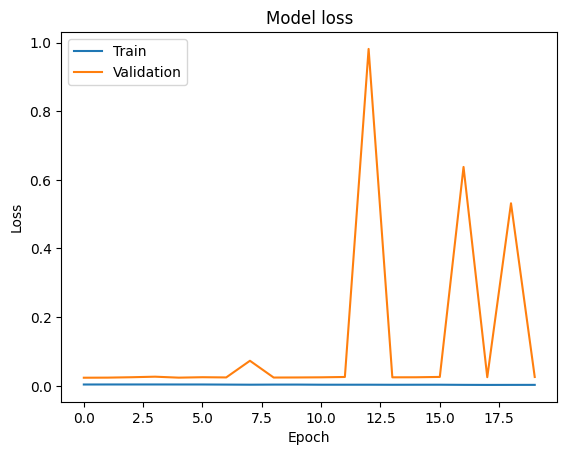

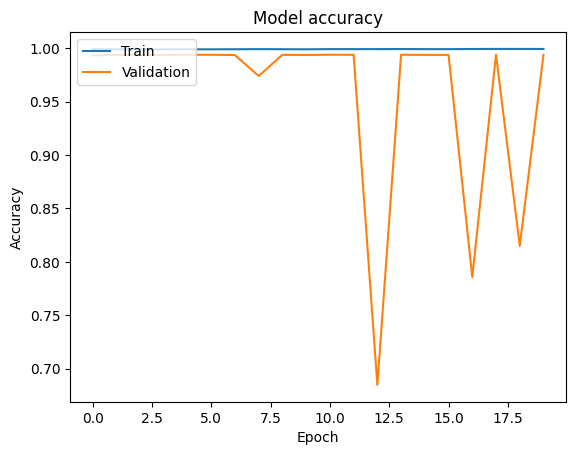

In [37]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [38]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X, Y, validation_data=(X_val, Y_val), epochs=20, callbacks=[early_stopping])

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 667ms/step - accuracy: 0.9993 - loss: 0.0024 - val_accuracy: 0.9937 - val_loss: 0.0254
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 0.9937 - val_loss: 0.0263
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - accuracy: 0.9995 - loss: 0.0020 - val_accuracy: 0.9937 - val_loss: 0.0259
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.9995 - loss: 0.0019 - val_accuracy: 0.9937 - val_loss: 0.0254
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.9995 - loss: 0.0020 - val_accuracy: 0.9937 - val_loss: 0.0260
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 0.9937 - val_loss: 0.0257


In [39]:
# Assuming X_test contains the test data
predictions = model.predict(X_val)

# Process predictions (e.g., get the class with the highest probability for each pixel)
predicted_classes = predictions.argmax(axis=-1)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


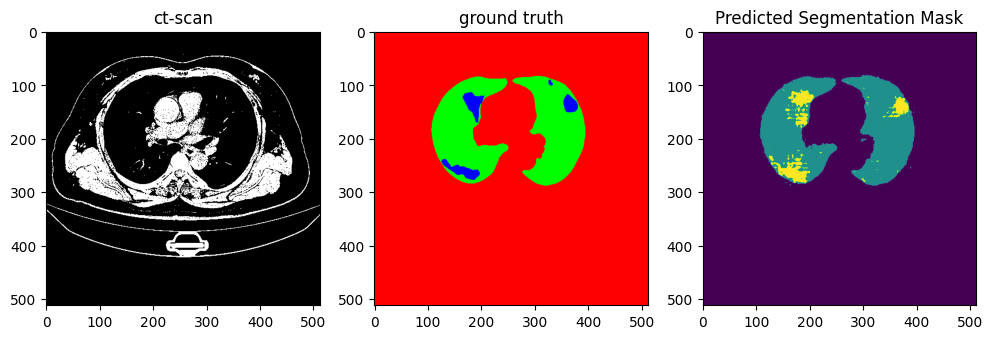

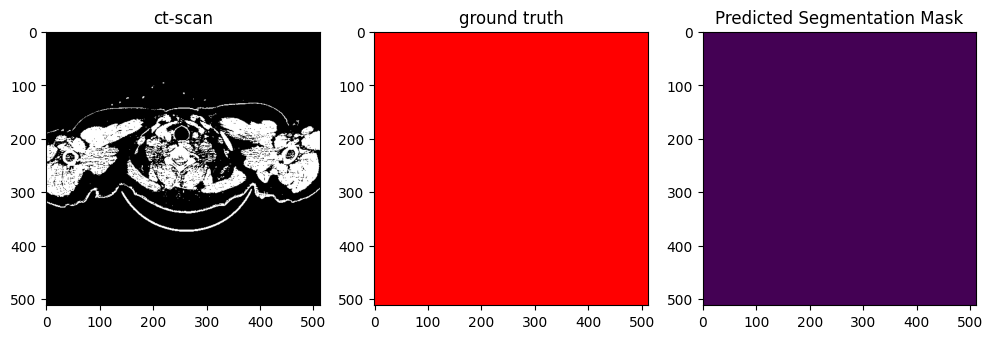

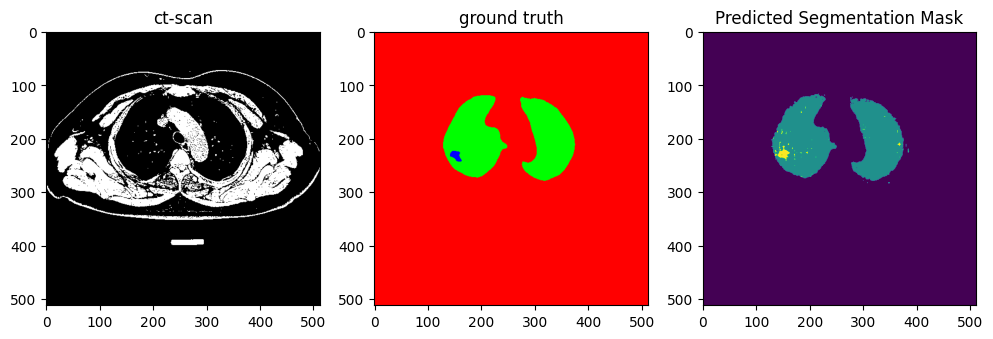

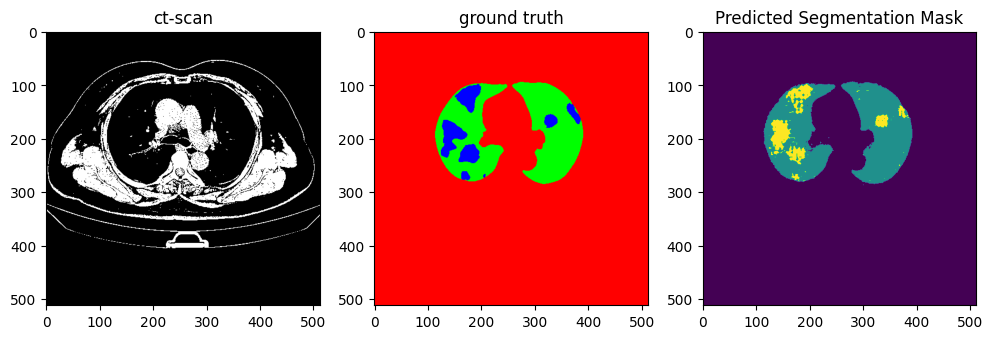

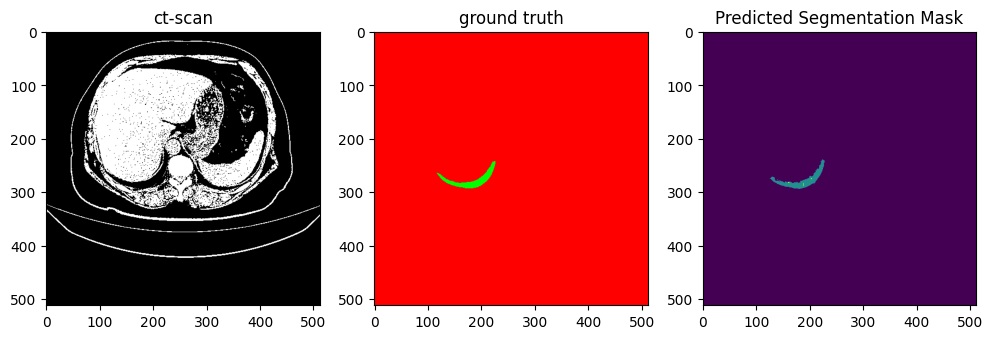

In [40]:
# Display the predicted segmentation mask for the first test image
for n in range(5):
    plt.figure(figsize=(12, 5))
    plt.subplot(1,3,1)
    plt.imshow(X_val[n])
    plt.title("ct-scan")
    plt.subplot(1,3,2)
    plt.imshow(Y_val[n])
    plt.title("ground truth")
    plt.subplot(1,3,3)
    plt.imshow(predicted_classes[n])
    plt.title("Predicted Segmentation Mask")
    plt.show()
    


In [41]:
test_loss, test_accuracy = model.evaluate(X_val, Y_val)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9935 - loss: 0.0263
Test Loss: 0.02540060132741928
Test Accuracy: 0.993723452091217


In [42]:
predictions.shape

(121, 512, 512, 3)

In [43]:
predicted_classes.shape

(121, 512, 512)

In [44]:
# Modify your metric functions to cast to float32 if needed and return scalar values
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2]) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    dice = (2 * intersection + smooth) / (tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2]) + smooth)
    return tf.reduce_mean(dice)

def precision(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    predicted_positives = tf.reduce_sum(y_pred, axis=[1, 2])
    precision = (true_positives + smooth) / (predicted_positives + smooth)
    return tf.reduce_mean(precision)

def recall(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    possible_positives = tf.reduce_sum(y_true, axis=[1, 2])
    recall = (true_positives + smooth) / (possible_positives + smooth)
    return tf.reduce_mean(recall)

def f1_score(y_true, y_pred, smooth=1e-6):
    prec = precision(y_true, y_pred, smooth)
    rec = recall(y_true, y_pred, smooth)
    return 2 * (prec * rec) / (prec + rec + smooth)

def accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_flat = tf.argmax(y_true, axis=-1)
    y_pred_flat = tf.argmax(y_pred, axis=-1)
    return tf.reduce_mean(tf.cast(tf.equal(y_true_flat, y_pred_flat), tf.float32))

# Example usage with a model's predictions
def evaluate_model_metrics(model, X_val, Y_val):
    Y_pred = model.predict(X_val)
    Y_pred = tf.one_hot(tf.argmax(Y_pred, axis=-1), depth=Y_val.shape[-1])  # Convert to one-hot encoding

    acc = accuracy(Y_val, Y_pred).numpy()
    iou = iou_metric(Y_val, Y_pred).numpy()
    dice = dice_coefficient(Y_val, Y_pred).numpy()
    prec = precision(Y_val, Y_pred).numpy()
    rec = recall(Y_val, Y_pred).numpy()
    f1 = f1_score(Y_val, Y_pred).numpy()

    print(f"Accuracy: {acc:.4f}")
    print(f"IoU: {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")

# Example call to the evaluation function
evaluate_model_metrics(model, X_val, Y_val)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Accuracy: 0.9937
IoU: 0.7320
Dice Coefficient: 0.7700
Precision: 0.7715
Recall: 0.9288
F1-Score: 0.8429


Accuracy: 0.9943 – This suggests that almost all of the predictions match the ground truth across the dataset.
IoU (Intersection over Union): 0.7284 – This measures how well the predicted masks overlap with the actual masks. An IoU of 0.7284 is quite good for segmentation tasks.
Dice Coefficient: 0.7640 – Similar to IoU, this indicates how well the model is predicting the segmentation, with a score of 1 being perfect overlap.
Precision: 0.7823 – This means that 78.23% of the pixels predicted as positive are actually correct.
Recall: 0.9137 – This is high, meaning that 91.37% of the actual positive pixels are correctly predicted by the model.
F1-Score: 0.8429 – The F1 score balances precision and recall, showing that the model has an overall good trade-off between them.

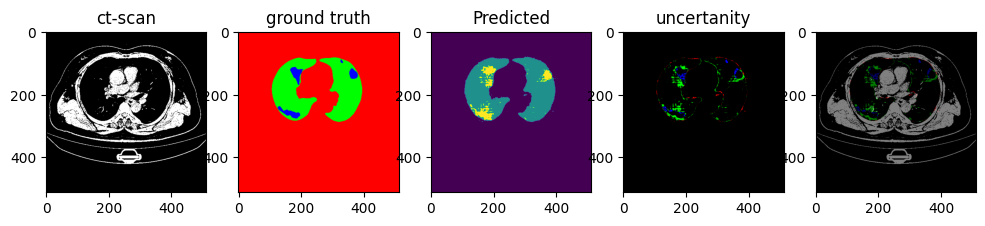

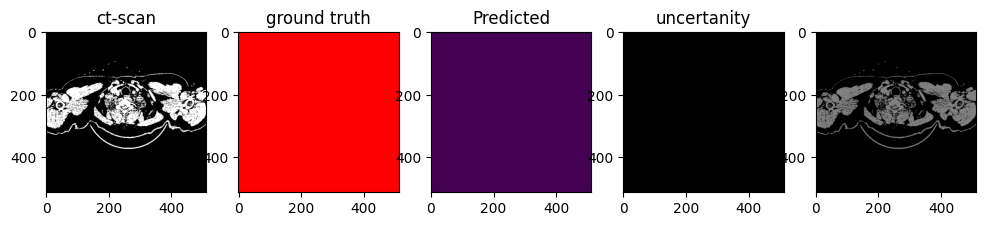

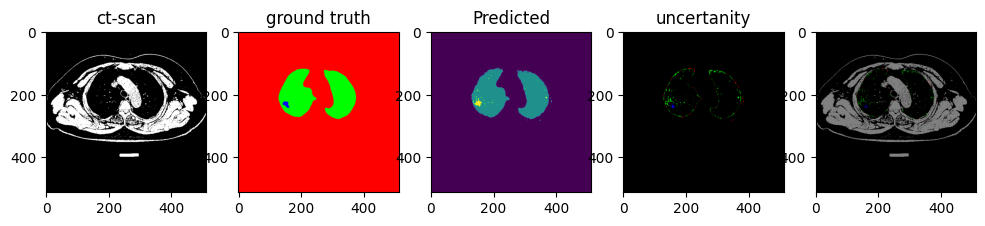

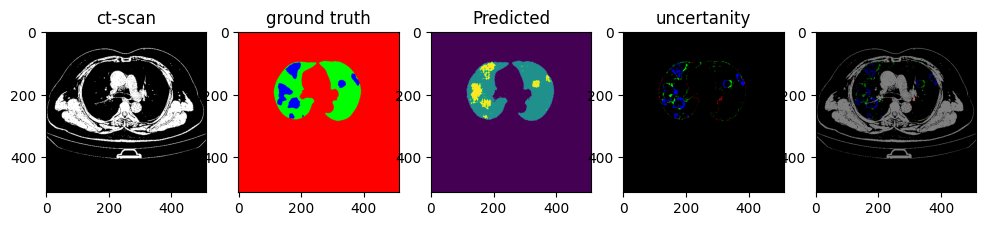

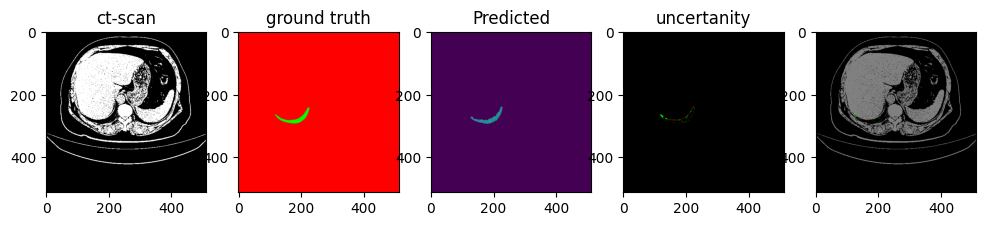

In [53]:
for n in range(5):
    plt.figure(figsize=(12, 5))
    plt.subplot(1,5,1)
    plt.imshow(X_val[n])
    plt.title("ct-scan")
    plt.subplot(1,5,2)
    plt.imshow(Y_val[n])
    plt.title("ground truth")
    plt.subplot(1,5,3)
    plt.imshow(predicted_classes[n])
    plt.title("Predicted")
    plt.subplot(1,5,4)
    plt.imshow(Y_val[n]-predictions[n])
    plt.title("uncertanity")
    plt.subplot(1, 5, 5)
    plt.imshow(X_val[n], cmap='gray')  # Display the CT scan
    plt.imshow(Y_val[n] - predictions[n], cmap='hot', alpha=0.5)  # Overlay uncertainty measure with transparency
    plt.show()

    
    

In [48]:
predictions.shape

(121, 512, 512, 3)

In [56]:
model.save('enet.h5')